<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/stateOfArt/PKG_UPENN_GBM_NIfTI_files_image_sliced_detection_along_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
based_path = r'/content/drive/MyDrive/PKG - UPENN-GBM NIFTI 3d to 2d exp 2/along z/patients data into 64 parts'

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


train_data_ids = [f.path for f in os.scandir(based_path)]

training_data_ids = pathListIntoIds(train_data_ids);

In [ ]:
training_data_ids.sort()

In [ ]:
len(training_data_ids)

69449

In [ ]:
training_data_ids[67110]

'UPENN-GBM-Patients-00049-slice051_z-4_36.png'

In [ ]:
data_ids = []
for i in range(len(training_data_ids)):
  test = training_data_ids[i].split('-')[3]
  if int(test) == 48:
    data_ids.append(training_data_ids[i])


In [ ]:
data_ids.sort()

In [ ]:
def fetch_blocks(block_no, ids):
  block = []
  for i in range(len(ids)):
    test0 = ids[i]
    test = test0.split('-')[5]
    test1 = test.split('_')[0]
    if test1 == str(block_no):
      block.append(test0)
  return block

In [ ]:
block = fetch_blocks(block_no=6, ids = data_ids)

In [ ]:
len(block)

456

In [ ]:
block[0]

'UPENN-GBM-Patients-00049-slice070_z-6_11.png'

In [ ]:
for i in range(len(block)):
  test3 = block[i].split('_')[2]
  test2 = test3.split('.')[0]
  if test2.isdigit() == False:
    block.remove(block[i])


In [ ]:
len(block)

456

In [ ]:
def data_prepare(ids):
  data_path = []
  data_ids = []
  desired_width = 30
  desired_height = 30
  for i in range(len(ids)):
    #path
    path = os.path.join(based_path, ids[i])
    #read images using its path
    img_data = cv2.imread(path)
    #removing rgb channel
    gray_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    #resizing if needed
    resized_image = cv2.resize(gray_image, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)
    #since the image class is marked in the image ids so we are fetching the image ids
    test1 = ids[i].split('_')[2]
    test = test1.split('.png')[0]
    data_path.append(resized_image)
    data_ids.append(int(test))
  #image data and image class are listed in a dataframe
  data_column = {'image_data': data_path,'class': data_ids}
  data_set = pd.DataFrame(data_column)
  data_list = data_set['image_data'].tolist()
  classes = data_set['class'].tolist()
  my_array = np.array(data_list)
  y_data = np.array(classes)
  #reshape the array for model execution
  x_data = np.array(my_array).reshape(-1,30,30,1)
  return x_data, y_data

In [ ]:
train, ids  = data_prepare(block)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train,ids, test_size=0.10)

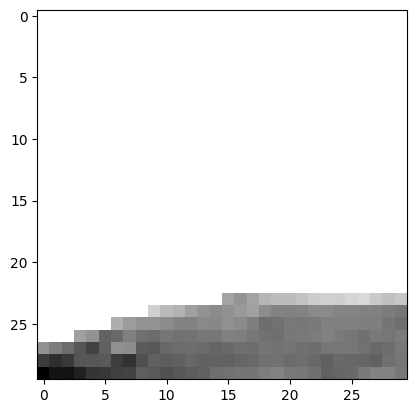

In [ ]:
from tensorflow.keras.utils import normalize

x_train = normalize(train, axis=1)
#x_test = normalize(x_test, axis=1)
plt.imshow(x_train[1], cmap =plt.cm.binary)

In [ ]:
x_train = np.array(x_train).reshape(-1,30,30,1)
x_test = np.array(x_test).reshape(-1,30,30,1)
print(x_train.shape,x_test.shape)

(9441, 30, 30, 1) (945, 30, 30, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import HeNormal

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Dense(64))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 15, 15, 64)        0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
h = model.fit(x_train, ids, batch_size = 32, validation_split= 0.1, epochs=100, callbacks=[checkpointer, earlystopping, reduce_lr])

In [ ]:
from tensorflow.keras.models import load_model

path =r"/content/drive/MyDrive/PKG - UPENN-GBM NIFTI 3d to 2d exp 2/model-along-z/model-long-z-block-6.hdf5"
model1 = load_model(path)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
test_loss, test_acc = model1.evaluate(x_train, ids)

15/15 [==============================] - 1s 22ms/step - loss: 1.3428 - accuracy: 0.8136


In [ ]:
Data_path1 =
path = os.path.join(Data_path1, f'{final_ids[200]}.nii')
img = nib.load(path)
img_data = img.get_fdata()
normalized_img = normalized_imgfunc(img_data)

plt.figure(figsize=(12, 4))

# Plot the first 2D NIfTI image
plt.subplot(131)  # 1 row, 3 columns, subplot 1
plt.imshow(normalized_img, cmap="gray")
plt.title("Image")


plt.tight_layout()
plt.show()

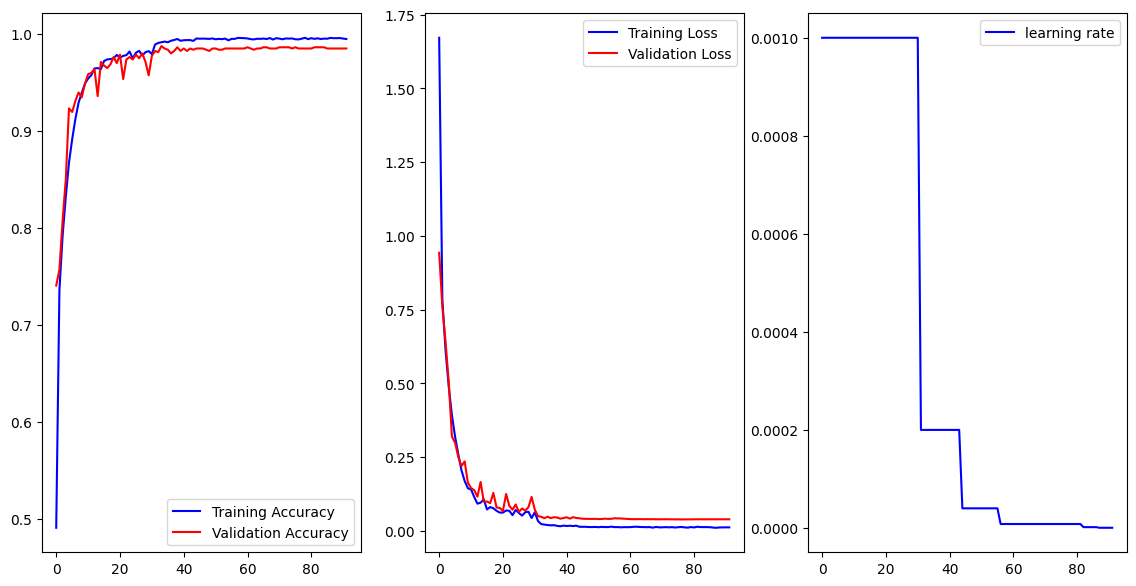

In [ ]:
acc=h.history['accuracy']
val_acc=h.history['val_accuracy']

epoch=range(len(acc))

loss=h.history['loss']
val_loss=h.history['val_loss']

learning_rate = h.history['lr']

f,ax=plt.subplots(1,3,figsize=(14,7))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()


ax[2].plot(epoch,learning_rate,'b',label='learning rate')
ax[2].legend()



plt.show()

In [ ]:
prediction = model.predict(x_test)

3/3 [==============================] - 0s 19ms/step


In [ ]:
len(prediction)

86

In [ ]:
not_match = []
not_match_ids = []
for i in range(len(prediction)):
  x = np.argmax(prediction[i])
  if x != y_test[i]:
    not_match.append(prediction[i])
    not_match_ids.append(i)

In [ ]:
for i in not_match_ids:
  print("Ids : ",i, "pred :",np.argmax(prediction[i]), "actual :", y_test[i])

Ids :  2 pred : 38 actual : 44
Ids :  4 pred : 30 actual : 21
Ids :  10 pred : 26 actual : 33
Ids :  12 pred : 20 actual : 21
Ids :  13 pred : 30 actual : 21
Ids :  14 pred : 14 actual : 23
Ids :  15 pred : 20 actual : 27
Ids :  45 pred : 39 actual : 31
Ids :  61 pred : 39 actual : 31
Ids :  85 pred : 20 actual : 44
